In [1]:
# Import necessary libraries
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler

# import yfinance as yf

from pyspark.sql.functions import desc, asc, col, avg

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2024-01-08 01:05:40.579587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Initialize a Spark session
spark = SparkSession.builder.appName("KLBFStock").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/08 01:05:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load your dataset into a DataFrame (replace 'your_dataset.csv' with your actual dataset file)
stock_data = spark.read.csv("KLBF.JK.csv", header=True, inferSchema=True)

# Get the data from yahoo finance
# start = '2018-01-01'
# end = '2023-12-31'

# stock_data = yf.download('KLBF.JK', start, end)
# stock_data.tail(10)

In [4]:
# Selecting relevant columns for modeling
# selected_data = stock_data.select("Date", "Open", "High", "Low", "Close", "Adj Close")
selected_data = stock_data
# stock_data.show()
# stock_data.sort(desc("Date")).show()

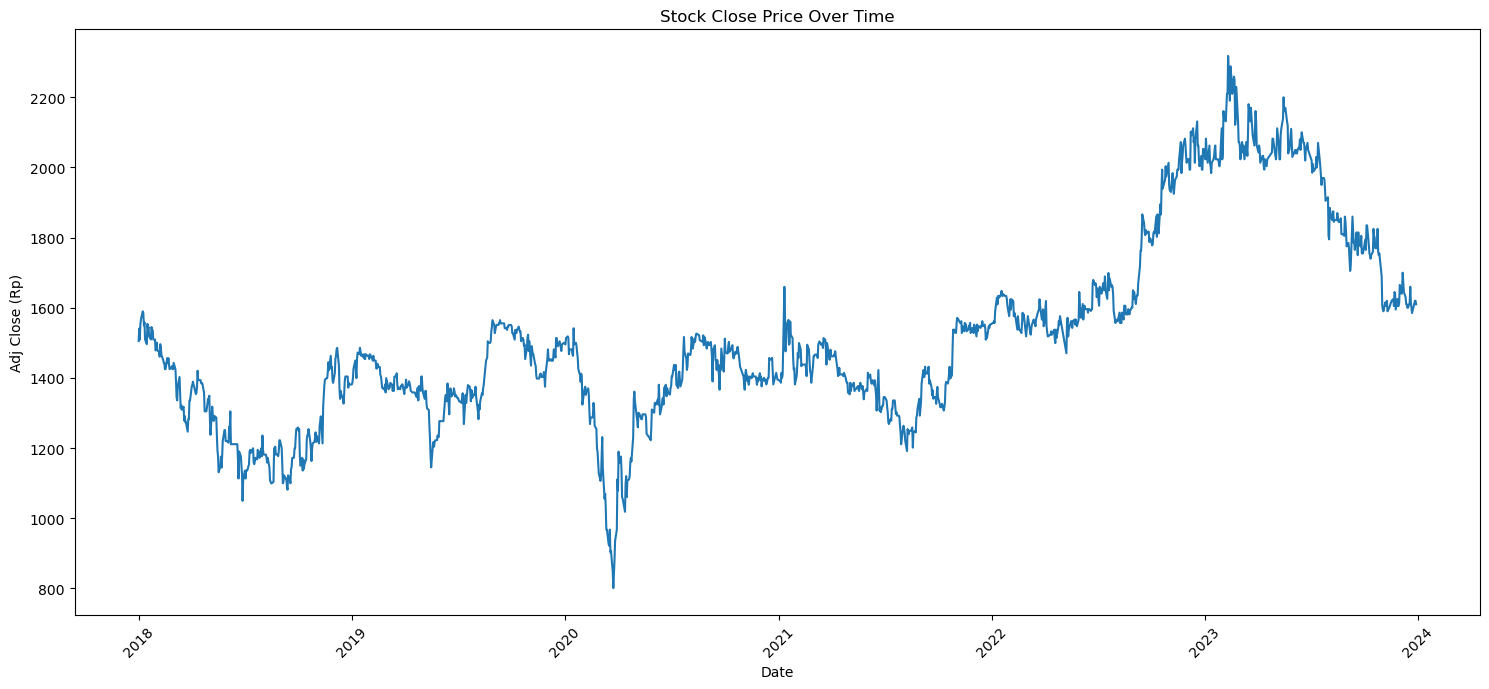

In [5]:
# Convert PySpark DataFrame to Pandas DataFrame for local plotting
pd_df = selected_data.toPandas()

# Sort data by date (optional, for visualization purposes)
pd_df = pd_df.sort_values('Date')

# Plotting the 'close' data over time using matplotlib
plt.figure(figsize=(15, 7))
plt.plot(pd_df['Date'], pd_df['Adj Close'])
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close (Rp)')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()

# Display the plot within PySpark environment
plt.show()

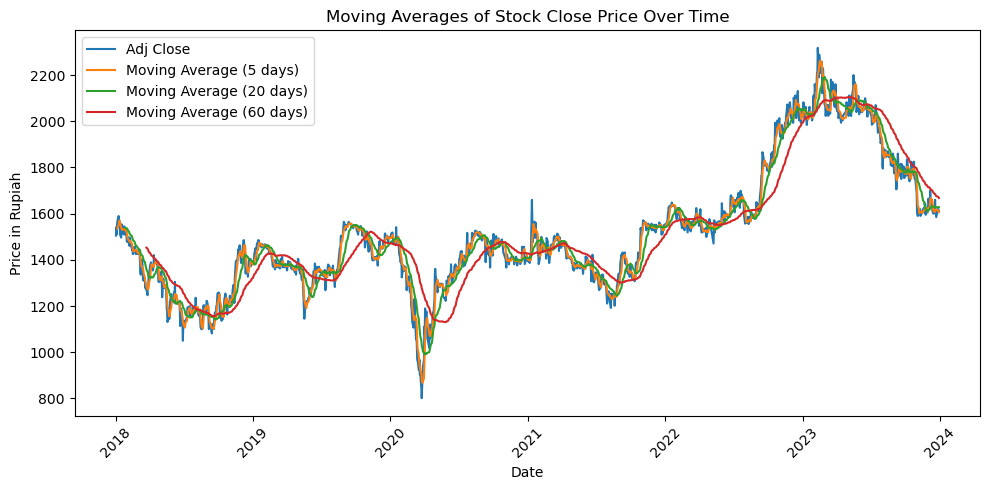

In [6]:
# Calculating moving averages for different window sizes
ma_day = [5, 20, 60]

for ma in ma_day:
  # Calculate moving average
  column_name = f"moving_avg_{ma}"
  pd_df[column_name] = pd_df['Adj Close'].rolling(ma).mean()

# Plotting the moving averages over time using Matplotlib
plt.figure(figsize=(10, 5))

# Plotting original 'close' data
plt.plot(pd_df['Date'], pd_df['Adj Close'], label='Adj Close')

# Plotting moving averages for different window sizes
for ma in ma_day:
  plt.plot(pd_df['Date'], pd_df[f"moving_avg_{ma}"], label=f'Moving Average ({ma} days)')

plt.title('Moving Averages of Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price in Rupiah')
plt.legend()
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()
plt.show()

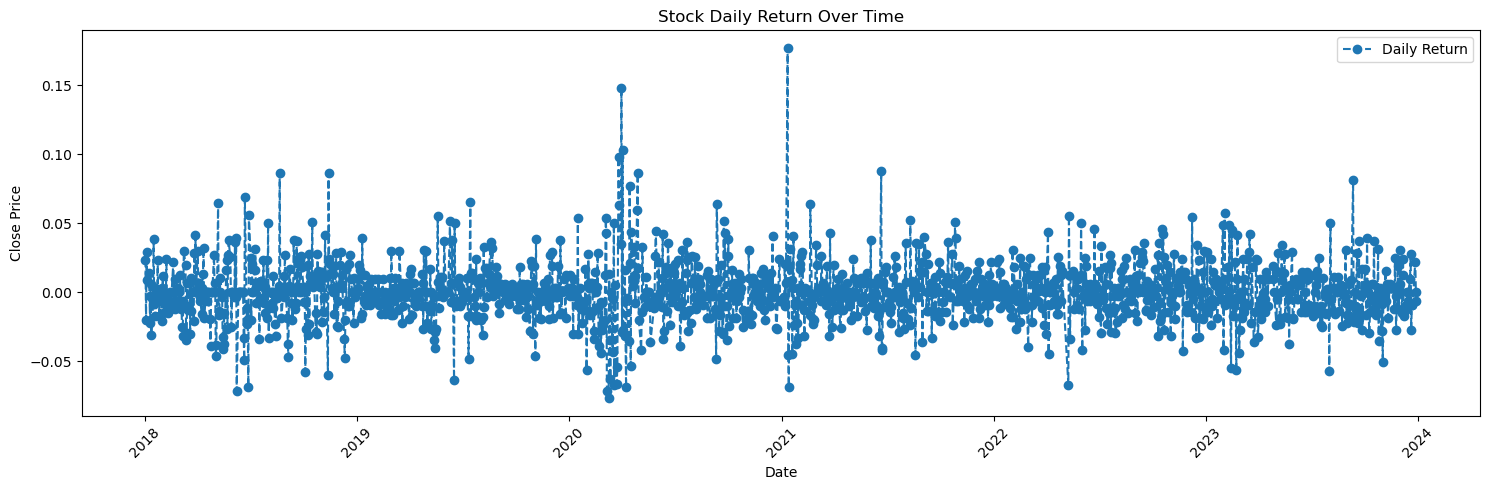

In [105]:
pd_df['dailyReturn'] = pd_df['Adj Close'].pct_change()
# Plotting the 'close' data over time using matplotlib
plt.figure(figsize=(15, 5))
plt.plot(pd_df['Date'], pd_df['dailyReturn'], label="Daily Return", linestyle='--', marker='o')
plt.title('Stock Daily Return Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.tight_layout()

# Display the plot within PySpark environment
plt.show()

Text(50, 50, 'Kalbe')

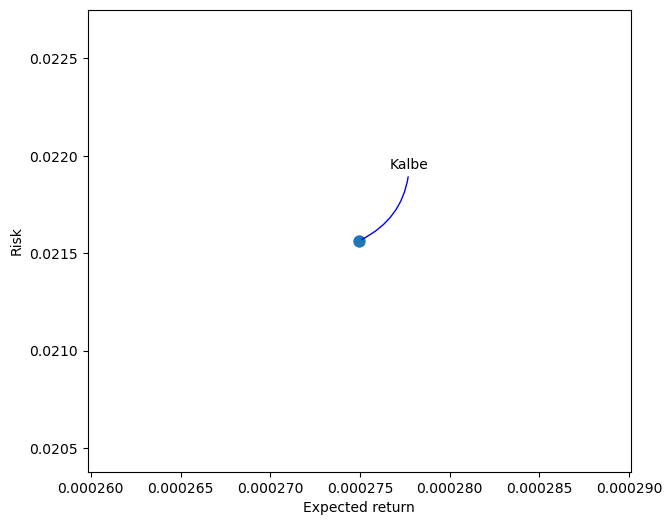

In [106]:
rets = pd_df['dailyReturn'].dropna()

area = np.pi * 20

plt.figure(figsize=(7, 6))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

# for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
plt.annotate("Kalbe", xy=(rets.mean(), rets.std()), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

In [82]:
# Create a new dataframe with only the 'Close column 
data = pd_df.filter(['Adj Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))

training_data_len

1195

In [83]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.46422947],
       [0.4877137 ],
       [0.46716494],
       ...,
       [0.53993872],
       [0.53993872],
       [0.53334661]])

In [84]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.46422947, 0.4877137 , 0.46716494, 0.49652019, 0.505327  ,
       0.52000467, 0.51706904, 0.4935848 , 0.4994559 , 0.46716494,
       0.45835821, 0.49652019, 0.4877137 , 0.49064925, 0.47303604,
       0.46716494, 0.49064925, 0.48477815, 0.48477815, 0.46716494,
       0.46716494, 0.44661617, 0.44955164, 0.46129384, 0.44661617,
       0.44368054, 0.43487397, 0.45835821, 0.45248719, 0.43780944,
       0.42900287, 0.42313194, 0.42313194, 0.41138966, 0.41138966,
       0.43193842, 0.42313194, 0.43193842, 0.42019631, 0.41138966,
       0.41432529, 0.41726068, 0.41138966, 0.41138966, 0.42313194,
       0.41138966, 0.38790526, 0.35854993, 0.35267883, 0.37909878,
       0.39671191, 0.36442103, 0.33800116, 0.34387234, 0.33506561,
       0.34093663, 0.31451677, 0.32332342, 0.3115813 , 0.3115813 ])]
[0.293968001056784]

[array([0.46422947, 0.4877137 , 0.46716494, 0.49652019, 0.505327  ,
       0.52000467, 0.51706904, 0.4935848 , 0.4994559 , 0.46716494,
       0.45835821, 0.49652019, 0.4877

In [101]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
36/36 [==============================] - 5s 43ms/step - loss: 0.0105
Epoch 2/50
36/36 [==============================] - 1s 41ms/step - loss: 0.0017
Epoch 3/50
36/36 [==============================] - 1s 39ms/step - loss: 0.0013
Epoch 4/50
36/36 [==============================] - 1s 39ms/step - loss: 0.0012
Epoch 5/50
36/36 [==============================] - 1s 41ms/step - loss: 0.0011
Epoch 6/50
36/36 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 7/50
36/36 [==============================] - 1s 39ms/step - loss: 9.8796e-04
Epoch 8/50
36/36 [==============================] - 1s 41ms/step - loss: 9.4061e-04
Epoch 9/50
36/36 [==============================] - 1s 41ms/step - loss: 9.2508e-04
Epoch 10/50
36/36 [==============================] - 2s 42ms/step - loss: 9.3568e-04
Epoch 11/50
36/36 [==============================] - 2s 44ms/step - loss: 0.0010
Epoch 12/50
36/36 [==============================] - 2s 41ms/step - loss: 8.9694e-04
Epoch 13/50
36/36

In [102]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

10/10 [==============================] - 1s 19ms/step


39.82899651027334

/var/folders/gp/l5rr_tyx2l1dz7bgljj1_ncr0000gn/T/ipykernel_6572/859690116.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


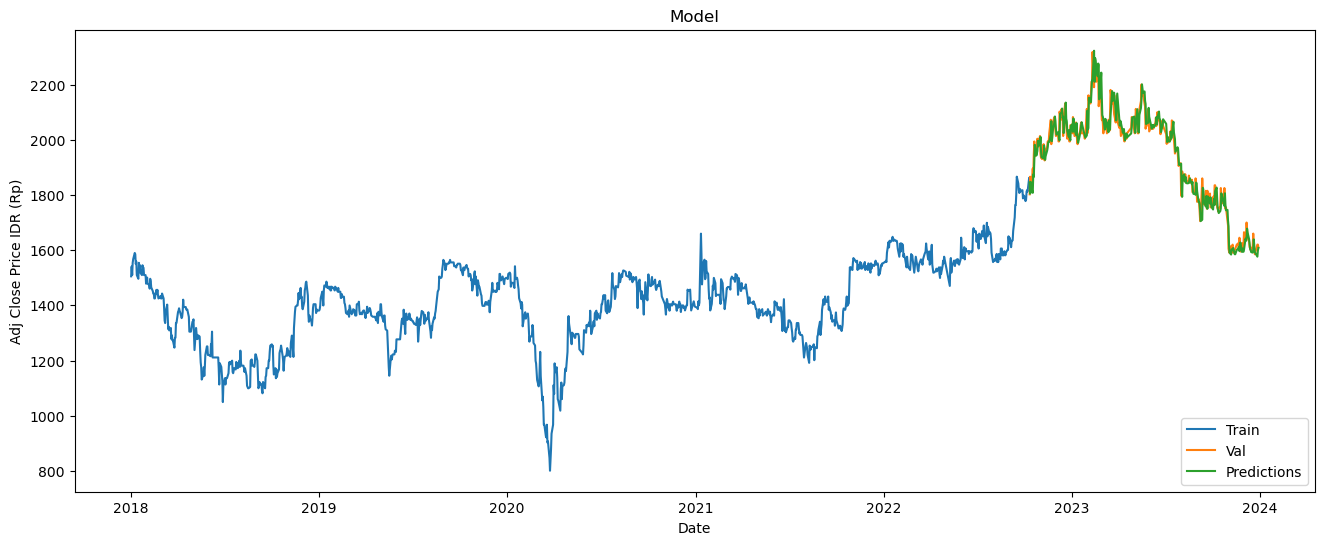

In [103]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Adj Close Price IDR (Rp)')
plt.plot(pd_df['Date'][:training_data_len], train['Adj Close'])
plt.plot(pd_df['Date'][-len(test_data) + 60:], valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [104]:
# Calculate average actual closing price
average_actual_price = np.mean(valid['Adj Close'])

# Calculate average predicted closing price
average_predicted_price = np.mean(valid['Predictions'])

print(f"Average Actual Closing Price: {average_actual_price}")
print(f"Average Predicted Closing Price: {average_predicted_price}")


Average Actual Closing Price: 1933.8794207315436
Average Predicted Closing Price: 1934.33740234375


In [107]:
valid

,Adj Close,Predictions
1195,1802.262939,1845.072998
1196,1866.103271,1804.851196
1197,1826.816895,1847.249023
1198,1812.084473,1825.910278
1199,1895.568115,1807.666626
...,...,...
1488,1600.000000,1614.680908
1489,1585.000000,1593.069824
1490,1620.000000,1576.434570
1491,1620.000000,1599.312866


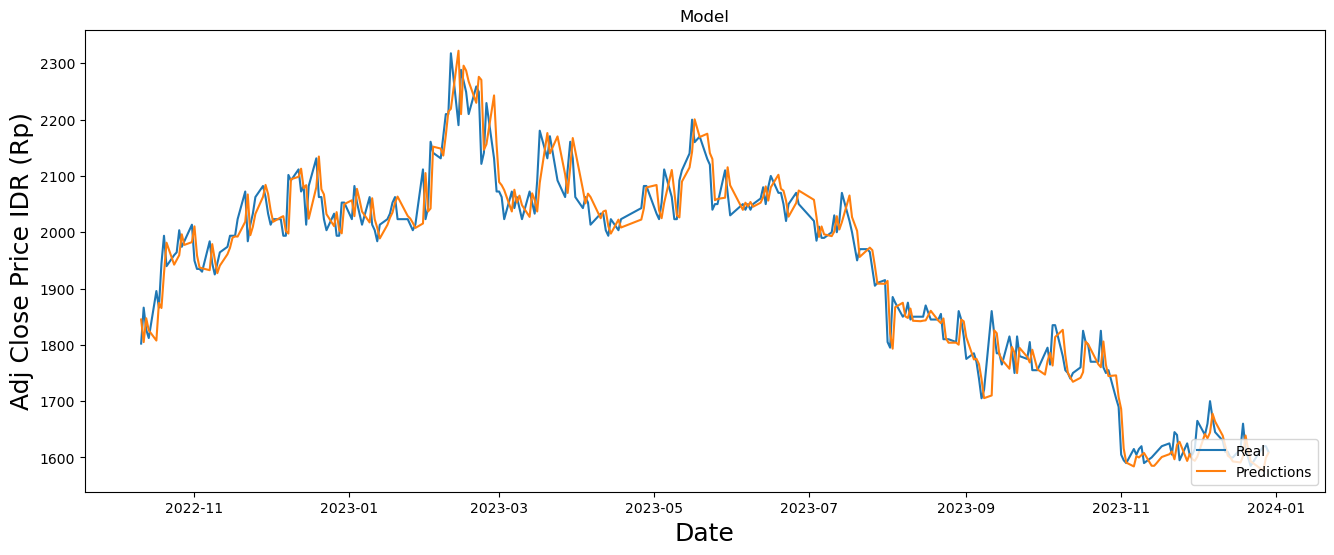

In [108]:

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Adj Close Price IDR (Rp)', fontsize=18)
plt.plot(pd_df['Date'][-len(test_data) + 60:], valid[['Adj Close', 'Predictions']])
plt.legend(['Real', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
# Assembling features into a single column 'features'
assembler = VectorAssembler(inputCols=["open", "high", "low"], outputCol="features")
assembled_data = assembler.transform(selected_data)

In [ ]:
# Splitting data into training and testing sets
(train_data, test_data) = assembled_data.randomSplit([0.8, 0.2])